# Adversarial Attack

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import cv2
from PIL import Image
import pandas as pd

In [3]:
# Metadaten für das Programm 
data = []
labels = []
height = 30
width = 30
channels = 3
classes = 43
input_size = height * width * channels

In [4]:
# Verkehrsschilder 
sign_label = ["20 km/h","30 km/h","50 km/h","60 km/h","70 km/h","80 km/h","80 km/h Aufhebung","100 km/h",
          "120 km/h", "Überholverbot", "LKW-Überholverbot", "Vorfahrt", "Vorfahrtsstraße","Vorfahrt gewähren", 
          "Stop","Fahrverbot","Verbot für Lastwagen","Einfahrt verboten","Gefahr","Linkskurve","Rechtskurve","Doppelkurve",
          "Bodenwelle","Schleudergefahr","Verengung","Baustelle","Ampel","Zebrastreifen","Kinder","Fahrradweg","Schneegefahr",
          "Wildwechsel","Unbegrenzte Geschwindigkeit","Rechtsabbiegen", "Linksabbiegen", "Geradeaus fahren", "Geradeaus oder Rechtsabbiegen",
          "Geradeaus oder Linksabbiegen", "Hindernis rechts umfahren", " Hindernis links umfahren", "Kreisverkehr", "Ende des Überholverbotes",
          "Ende des LKW-Überholverbotes"]

In [5]:
# Laden der Test-Daten CSV
y_test=pd.read_csv(r'.\Test.csv')
names =y_test['Path'].to_numpy()
y_test =y_test['ClassId'].values
data=[]

In [6]:
# Laden der Test-Daten Bilder
from tqdm import tqdm
for f in tqdm(names):
    image=cv2.imread(r'.\Test/'+f.replace('Test', ''))
    image_from_array = Image.fromarray(image, 'RGB')
    size_image = image_from_array.resize((height, width))
    data.append(np.array(size_image))

100%|██████████| 12630/12630 [00:27<00:00, 452.98it/s]


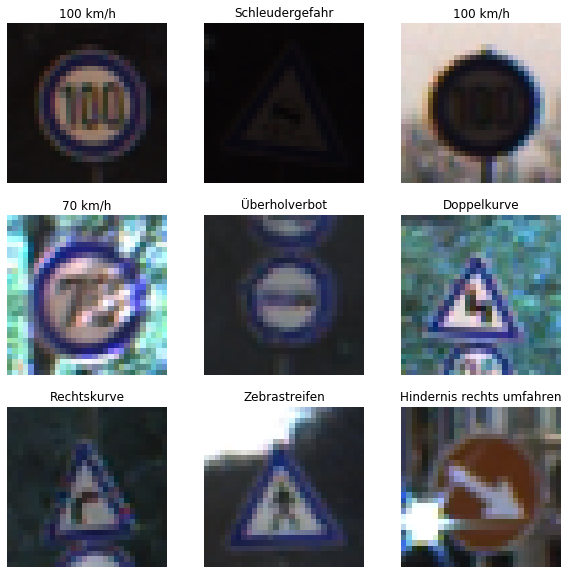

In [7]:
# Beispiele aus dem Test Dataset
fig=plt.figure(figsize=(10, 10))
columns = 3
rows = 3

for i in range(1, columns*rows +1):
    x = i+10
    fig.add_subplot(rows, columns, i)
    plt.imshow(data[x])
    plt.title(sign_label[y_test[x]])
    plt.axis("off")
plt.show()

In [8]:
model = keras.models.load_model("Traffic_Sign_Net")

In [9]:
x_test=np.array(data)
x_test = x_test.astype('float32')/255
pred = model.predict(x_test)
print("Anzahlder Predictions:",len(pred))

Anzahlder Predictions: 12630


# Attacke FGSM

In [10]:
# Funktion um ein adversarial_pattern zu erstellen
def adversarial_pattern(image, label):
    image = tf.cast(image, tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.MSE(label, prediction)
    
    gradient = tape.gradient(loss, image)
    
    signed_grad = tf.sign(gradient)
    
    return signed_grad

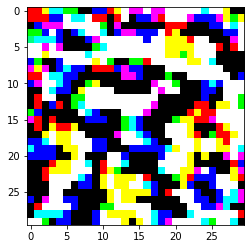

In [11]:
# Darstellung des Patterns 
i = 408 #408, 7, 10, 14

image = x_test[i]
image = image.reshape(1, height, width, channels)

image_label = y_test[i] # y_test[i]
image_probs = model.predict(image)

label = tf.one_hot(image_label, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = adversarial_pattern(image, label)
plt.imshow(perturbations[0]*0.5+0.5); # To change [-1, 1] to [0,1]

In [12]:
max_iterations = 0.03
confidence = 0.9

for x in np.arange(0.0, max_iterations, 0.001):
    
    adversarial = image + perturbations * x
    adversarial = tf.clip_by_value(adversarial, -1, 1)
    
    original_prediction = sign_label[model.predict(image).argmax()]
    adversarial_prediction = sign_label[model.predict(adversarial).argmax()]
    
    print("Noise:", round(x,3), 
          "\t Confidence",round(max(model.predict(adversarial)[0]), 3),
          "\t Prediction",adversarial_prediction)
    
    if original_prediction != adversarial_prediction and \
    max(model.predict(adversarial)[0]) > confidence:
        noise = x
        break

Noise: 0.0 	 Confidence 1.0 	 Prediction 80 km/h
Noise: 0.001 	 Confidence 1.0 	 Prediction 80 km/h
Noise: 0.002 	 Confidence 1.0 	 Prediction 80 km/h
Noise: 0.003 	 Confidence 1.0 	 Prediction 80 km/h
Noise: 0.004 	 Confidence 1.0 	 Prediction 80 km/h
Noise: 0.005 	 Confidence 1.0 	 Prediction 80 km/h
Noise: 0.006 	 Confidence 1.0 	 Prediction 80 km/h
Noise: 0.007 	 Confidence 0.999 	 Prediction 80 km/h
Noise: 0.008 	 Confidence 0.998 	 Prediction 80 km/h
Noise: 0.009 	 Confidence 0.994 	 Prediction 80 km/h
Noise: 0.01 	 Confidence 0.983 	 Prediction 80 km/h
Noise: 0.011 	 Confidence 0.949 	 Prediction 80 km/h
Noise: 0.012 	 Confidence 0.865 	 Prediction 80 km/h
Noise: 0.013 	 Confidence 0.718 	 Prediction 80 km/h
Noise: 0.014 	 Confidence 0.511 	 Prediction 80 km/h
Noise: 0.015 	 Confidence 0.67 	 Prediction 60 km/h
Noise: 0.016 	 Confidence 0.794 	 Prediction 60 km/h
Noise: 0.017 	 Confidence 0.88 	 Prediction 60 km/h
Noise: 0.018 	 Confidence 0.931 	 Prediction 60 km/h


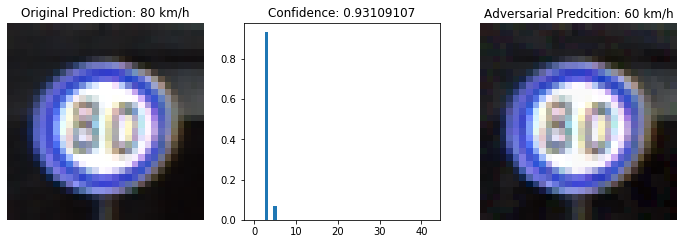

In [13]:
# Ergebnisse der Attacke darstellen
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize = (12, 12))

y = [i for i in range(len(sign_label))]

ax1.imshow(image[0])
ax2.bar(y, model.predict(adversarial)[0])
ax3.imshow(adversarial[0])

asp = np.diff(ax2.get_xlim())[0] / np.diff(ax2.get_ylim())[0]
ax2.set_aspect(asp)

ax1.axis("off")
ax3.axis("off")

ax1.title.set_text("Original Prediction: "+str(original_prediction))
ax2.title.set_text("Confidence: "+ str(max(model.predict(adversarial)[0])))
ax3.title.set_text("Adversarial Predcition: " + str(adversarial_prediction))
plt.show()

# Rescaling

In [14]:
def rescaler(image, size):
    image_reshaped = image.reshape(height, width, channels)
    image_from_array = Image.fromarray(image_reshaped, 'RGB')
    size_image = image_from_array.resize((size, size))
    image_array = np.array(size_image)
    return image_array

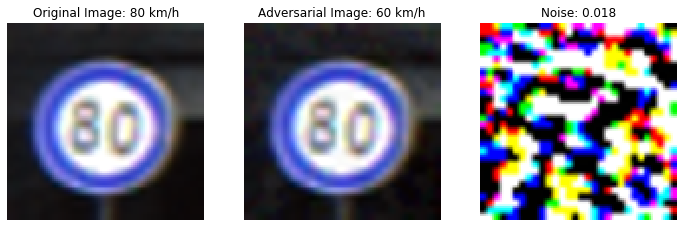

In [15]:
# Ergebnisse der Attacke darstellen
adversarial_image = adversarial.numpy()
adversarial_image = adversarial_image * 255
adversarial_image = adversarial_image.astype('uint8')
adversarial_image = rescaler(adversarial_image, 100)

perturbations_pattern = perturbations.numpy()
perturbations_pattern = perturbations_pattern * 255
perturbations_pattern = perturbations_pattern.astype('uint8')
perturbations_pattern = rescaler(perturbations_pattern, 100)

original_image = image
original_image = original_image * 255
original_image = original_image.astype('uint8')
original_image = rescaler(original_image, 100)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize = (12, 12))

ax1.imshow(original_image)
ax2.imshow(adversarial_image)
ax3.imshow(perturbations_pattern)

ax1.axis("off")
ax2.axis("off")
ax3.axis("off")

ax1.title.set_text("Original Image: "+str(original_prediction))
ax2.title.set_text("Adversarial Image: "+ str(adversarial_prediction))
ax3.title.set_text("Noise: " + str(round(noise,3)))
plt.show()

# Downscaling

In [16]:
def downscaler(image):
    image_from_array = Image.fromarray(image, 'RGB')
    size_image = image_from_array.resize((height, width))
    array_image = np.array(size_image)
    array_image = array_image.astype('float32')/255
    array_image = array_image.reshape(1, height, width, channels)
    return array_image


In [17]:
adversarial_down_image = downscaler(adversarial_image)
print("Vorhersage für das neu skallierte Bild:",\
      sign_label[model.predict(adversarial_down_image).argmax()])

Vorhersage für das neu skallierte Bild: 60 km/h


# Gesamt Attacke

In [18]:
# Funktion zum manipulieren des Datensets

def giant_attack(dataset_images, dataset_labels, iterations = False, max_iterations = 0.03, confidence = 0.9):
    
    attacked_dataset = []
    
    for i in tqdm(range(len(dataset_images))):
        image = dataset_images[i]
        image = image.reshape(1, height, width, channels)

        image_label = dataset_labels[i]
        image_probs = model.predict(image)

        label = tf.one_hot(image_label, image_probs.shape[-1])
        label = tf.reshape(label, (1, image_probs.shape[-1]))

        perturbations = adversarial_pattern(image, label)

        if iterations:
            for x in np.arange(0.0, max_iterations, 0.001):

                adversarial = image + perturbations * x
                adversarial = tf.clip_by_value(adversarial, -1, 1)

                original_prediction = sign_label[model.predict(image).argmax()]
                adversarial_prediction = sign_label[model.predict(adversarial).argmax()]

                if original_prediction != adversarial_prediction and \
                    max(model.predict(adversarial)[0]) > confidence:
                    noise = x
                    break
        else:
            adversarial = image + perturbations * max_iterations
            adversarial = tf.clip_by_value(adversarial, -1, 1)
            
        attacked_dataset.append(np.array(adversarial))
        
    return attacked_dataset

In [19]:
attacked_dataset = giant_attack(x_test, y_test, max_iterations = 0.05 )

100%|██████████| 12630/12630 [05:13<00:00, 40.30it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


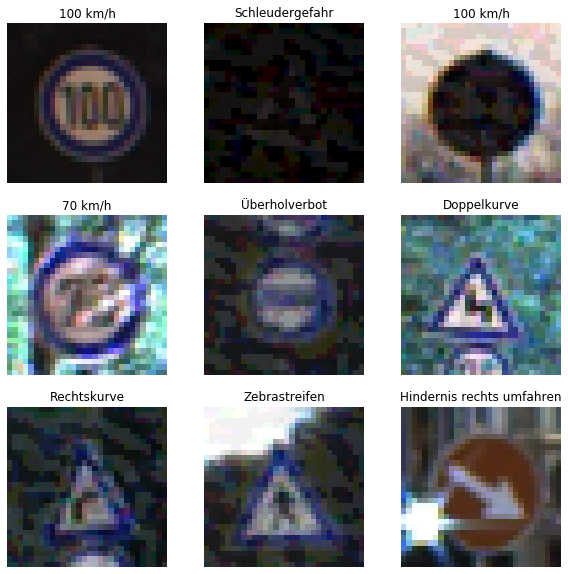

In [20]:
# Beispiele aus dem Attacked Dataset
fig=plt.figure(figsize=(10, 10))
columns = 3
rows = 3

for i in range(1, columns*rows +1):
    x = i+10
    fig.add_subplot(rows, columns, i)
    plt.imshow(attacked_dataset[x][0])
    plt.title(sign_label[y_test[x]])
    plt.axis("off")
plt.show()

In [21]:
adversarial_predictions = []
attacked_dataset=np.array(attacked_dataset)

for i in tqdm(range(len(attacked_dataset))):
    attacked_pred = model.predict(attacked_dataset[i])
    adversarial_predictions.append(attacked_pred.argmax())

100%|██████████| 12630/12630 [03:59<00:00, 52.77it/s]


In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [23]:
cm = confusion_matrix(y_test, adversarial_predictions)

In [24]:
df_cm = pd.DataFrame(cm, index = [i for i in sign_label],
                          columns = [i for i in sign_label])

df_perc = pd.DataFrame()
for i in sign_label:
    row = (df_cm[i] / df_cm[i].sum()) * 100
    df_perc = pd.concat([df_perc, row],axis=1)

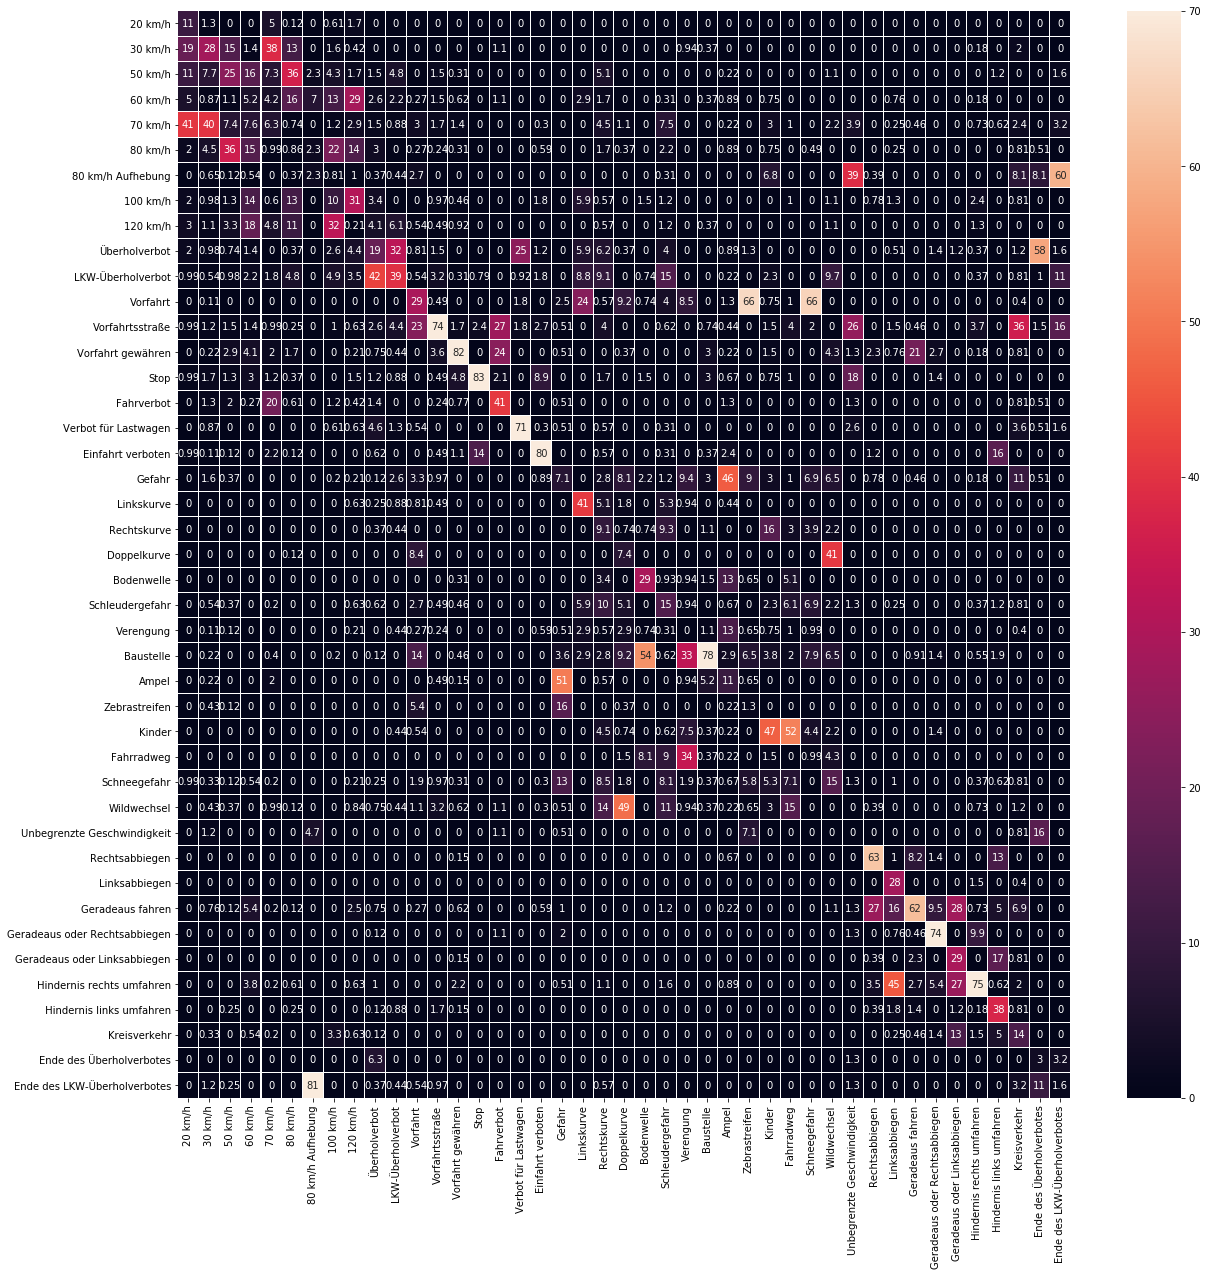

In [25]:
df_perc.round(0)
plt.figure(figsize = (20,20))
svm = sn.heatmap(df_perc, annot=True,vmin=0, vmax=70, linewidths=0.01)
figure = svm.get_figure() 
figure.savefig('cm_adversarial_percentage.png', dpi=400)